# 🛡️ NPL-Sentinel

![NPL Sentinel Banner](https://github.com/lucianoayres/npl-sentinel/raw/main/images/sentinel_banner.png)


## Análise de Sentimento em Avaliações de Produtos

- #### Curso: Pós-Graduação em Deep Learning (CIn - UFPE)
- ##### Disciplina: Processamento de Linguagem Natural  
  - ##### Professor: Luciano Barbosa

- ##### 👥 Grupo:
  - Paloma Corrêa Alves (pca2@cin.ufpe.br)
  - Luciano Ayres Farias de Carvalho (lafc@cin.ufpe.br)

## 📖 Sobre o Projeto

### 🔍 Visão Geral  
O **NPL-Sentinel** é um projeto que explora **Processamento de Linguagem Natural (PLN)** para analisar sentimentos expressos em avaliações de consumidores sobre um produto: um **smartphone**. 📱✨

### 🎯 Objetivo  
Este projeto tem como **meta principal** identificar a polaridade dos sentimentos (😊 Positivo, 😐 Neutro, 😞 Negativo) contidos nas avaliações dos consumidores. Além disso:  
- **📈 Correlacionar** a polaridade dos sentimentos com as notas atribuídas pelos consumidores, validando a precisão do modelo.  
- **🔍 Realizar análises exploratórias** para identificar padrões nas avaliações, destacando os aspectos mais comentados em avaliações positivas e negativas.  

### 🤖 Modelos Utilizados  
🔹 **SVM + Bag of Words (BoW)**  
🔹 **SVM + Embeddings**  
🔹 **BERT**  
🔹 **In-Context Learning**: OpenAI  
🔹 **In-Content Learning**: Google Gemini  

### 📑 Sobre os Dados  
Os dados utilizados consistem em:  
- **💬 review:** Comentário livre do consumidor sobre o produto (smartphone).  
- **⭐ rating:** Nota (1 a 5) atribuída pelo consumidor, indicando sua satisfação com o smartphone.  

### 💡 Por que NPL-Sentinel?  
Porque a ideia é ir além da análise básica, atuando como um "sentinela" que monitora tendências, sentimentos e insights valiosos diretamente das opiniões dos consumidores. 🚀

# 1. Carregamento dos Dados

In [ ]:
import pandas as pd

# URL do arquivo CSV remoto
url = "https://raw.githubusercontent.com/lucianoayres/npl-sentinel/refs/heads/main/data/reviews.csv"

# Carrega o arquivo CSV em um DataFrame do pandas
df = pd.read_csv(url)

# Salva o DataFrame localmente no Google Colab
df.to_csv("reviews.csv", index=False)

# Exibe as primeiras linhas do DataFrame (opcional)
print(df.head())

                                              review  rating
0  Material de ótima qualidade, mas um pouco pesado.       4
1  O celular possui um bom sistema de segurança i...       3
2  O celular possui um bom sistema de gerenciamen...       3
3  As atualizações de software são frequentes, ma...       3
4  O celular tem um sensor de batimentos cardíaco...       3


In [ ]:
# Exibe tipos de dados de cada coluna
print("\nTipos de dados de cada coluna:")
df.info()


Tipos de dados de cada coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4197 entries, 0 to 4196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  4197 non-null   object
 1   rating  4197 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.7+ KB


In [ ]:
# Imprime um describe detalhado, incluindo todas as colunas
print("\nDescrição detalhada dos dados:")
print(df.describe(include='all'))


Descrição detalhada dos dados:
                                                   review       rating
count                                                4197  4197.000000
unique                                               3994          NaN
top     O aparelho possui um bom equilíbrio entre func...          NaN
freq                                                    3          NaN
mean                                                  NaN     3.234691
std                                                   NaN     1.439586
min                                                   NaN     1.000000
25%                                                   NaN     2.000000
50%                                                   NaN     3.000000
75%                                                   NaN     5.000000
max                                                   NaN     5.000000


In [ ]:
# Estatísticas descritivas para variáveis categóricas
print("\nEstatísticas descritivas para variáveis categóricas:")
print(df.describe(include=['object']))


Estatísticas descritivas para variáveis categóricas:
                                                   review
count                                                4197
unique                                               3994
top     O aparelho possui um bom equilíbrio entre func...
freq                                                    3


# 2. Pré-processamento dos Dados

Uso do `nltk` para tokenização, remoção de stopwords e outras técnicas de limpeza.

In [ ]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import string
import pandas as pd  # Ensure pandas is imported

# Faz o download das stopwords
nltk.download("stopwords")
stop_words = stopwords.words("portuguese")

# Função para pré-processar o texto
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Retorna string vazia se o texto não for string
    text = text.lower()  # Converte para minúsculas
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove pontuação
    text = "".join([char for char in text if char.isalnum() or char.isspace()])  # Remove caracteres não alfanuméricos
    tokens = [word for word in text.split() if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)  # Junta os tokens de volta em uma string

# Verifica e remove linhas com review ou rating vazio antes de qualquer processamento
empty_reviews = df["review"].isnull() | (df["review"].astype(str).str.strip() == "")
empty_ratings = df["rating"].isnull() | (df["rating"].astype(str).str.strip() == "")
initial_count = df.shape[0]
df = df[~(empty_reviews | empty_ratings)].copy()
removed_reviews = initial_count - df.shape[0]

# Exibe a quantidade de reviews e ratings vazios removidos
print("\nItens Removidos:")
print("Reviews ou Ratings vazios:", removed_reviews)

# Converte a coluna 'rating' para inteiro, tratando possíveis erros
df["rating"] = pd.to_numeric(df["rating"], errors='coerce')

# Remove quaisquer linhas onde a conversão falhou (resultado em NaN)
invalid_ratings = df["rating"].isnull()
if invalid_ratings.any():
    print(f"Removendo {invalid_ratings.sum()} linhas com ratings inválidos após conversão.")
    df = df[~invalid_ratings]

# Aplica a função de pré-processamento à coluna 'review'
df["clean_review"] = df["review"].apply(preprocess_text)

# Função para converter notas em rótulos de sentimento
def convert_to_sentiment(rating):
    if rating >= 4:
        return "positivo"
    elif rating <= 2:
        return "negativo"
    else:
        return "neutro"

# Aplica a função de conversão à coluna 'rating'
df["sentiment"] = df["rating"].apply(convert_to_sentiment)

# Opcional: Exibe um resumo das conversões
print("\nDistribuição de Sentimentos:")
print(df["sentiment"].value_counts())

# Exemplo de visualização do DataFrame resultante
print("\nExemplo de dados processados:")
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Itens Removidos:
Reviews ou Ratings vazios: 0

Distribuição de Sentimentos:
sentiment
positivo    1918
negativo    1339
neutro       940
Name: count, dtype: int64

Exemplo de dados processados:
                                              review  rating  \
0  Material de ótima qualidade, mas um pouco pesado.       4   
1  O celular possui um bom sistema de segurança i...       3   
2  O celular possui um bom sistema de gerenciamen...       3   
3  As atualizações de software são frequentes, ma...       3   
4  O celular tem um sensor de batimentos cardíaco...       3   

                                        clean_review sentiment  
0              material ótima qualidade pouco pesado  positivo  
1     celular possui bom sistema segurança integrado    neutro  
2  celular possui bom sistema gerenciamento aplic...    neutro  
3  atualizações software frequentes sempre resolv...    neutro  
4      celular sensor batimentos cardíacos integrado    neutro  


# 3. Análise Descritiva

## 3.1. Distribuição das Notas (rating)

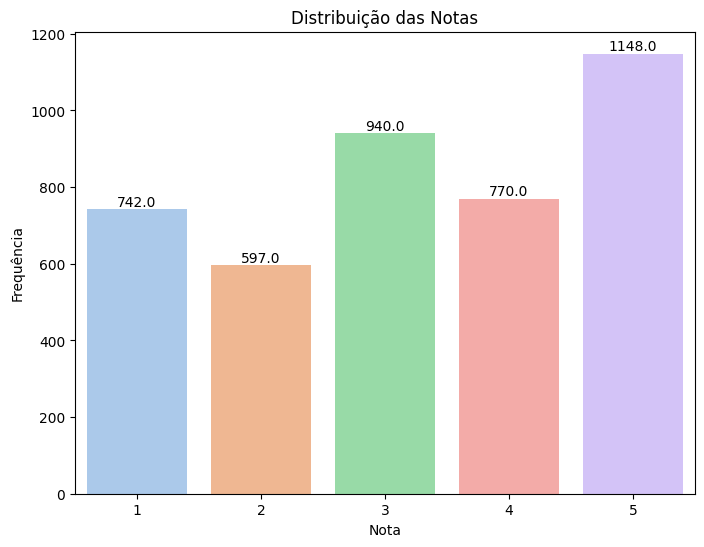

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Análise da Distribuição das Notas
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='rating', data=df, hue='rating', palette='pastel', legend=False)  # Changes here

# Adiciona os totais em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribuição das Notas')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()

### Resultados Totais da Distribuição das Notas

In [ ]:
# Imprime os totais para cada nota
print("\nResultados Totais da Distribuição das Notas:")
rating_counts = df['rating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    print(f"Nota {rating}: {count} avaliações")


Resultados Totais da Distribuição das Notas:
Nota 1: 742 avaliações
Nota 2: 597 avaliações
Nota 3: 940 avaliações
Nota 4: 770 avaliações
Nota 5: 1148 avaliações


## 3.2. Histograma do Comprimento das Avaliações (review)


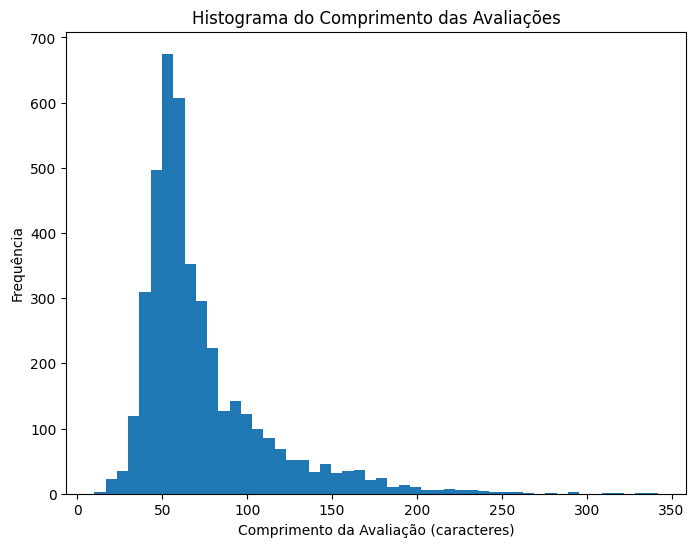

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['review'].str.len(), bins=50)
plt.title('Histograma do Comprimento das Avaliações')
plt.xlabel('Comprimento da Avaliação (caracteres)')
plt.ylabel('Frequência')
plt.show()

### Estatísticas do Comprimento das Avaliações

In [ ]:
import pandas as pd
import numpy as np

review_lengths = df['review'].str.len()
hist, bin_edges = np.histogram(review_lengths, bins=50) # Calculate hist and bin_edges

# Cria um DataFrame para estatísticas resumidas
summary_data = {
    "Métrica": ["Total de Avaliações", "Comprimento Médio", "Comprimento Mínimo", "Comprimento Máximo", "Desvio Padrão"],
    "Valor": [
        len(review_lengths),
        f"{review_lengths.mean():.2f} caracteres",
        f"{review_lengths.min()} caracteres",
        f"{review_lengths.max()} caracteres",
        f"{review_lengths.std():.2f} caracteres",
    ],
}
summary_df = pd.DataFrame(summary_data)

# Cria um DataFrame para a distribuição de comprimentos
distribution_data = {
    "Intervalo de Comprimento": [f"{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}" for i in range(len(hist))],
    "Frequência (Avaliações)": hist,
}
distribution_df = pd.DataFrame(distribution_data)

# Exibe as tabelas
print("Estatísticas Resumidas:")
print(summary_df.to_string(index=False))  # index=False para ocultar os números das linhas

print("\nDistribuição de Comprimentos:")
print(distribution_df.to_string(index=False))

Estatísticas Resumidas:
            Métrica            Valor
Total de Avaliações             4197
  Comprimento Médio 73.36 caracteres
 Comprimento Mínimo    10 caracteres
 Comprimento Máximo   342 caracteres
      Desvio Padrão 37.29 caracteres

Distribuição de Comprimentos:
Intervalo de Comprimento  Frequência (Avaliações)
                   10-17                        2
                   17-23                       23
                   23-30                       35
                   30-37                      120
                   37-43                      310
                   43-50                      496
                   50-56                      675
                   56-63                      607
                   63-70                      353
                   70-76                      295
                   76-83                      223
                   83-90                      127
                   90-96                      143
                  96-10

## 3.3. Nuvem de Palavras


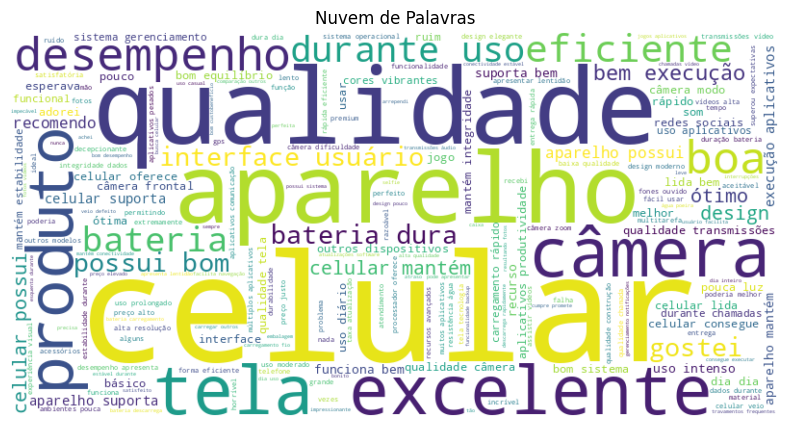

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
text = ' '.join(df['clean_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras')
plt.show()

### Resultados para a Nuvem de Palavras

In [ ]:
import pandas as pd

# Obter as palavras mais frequentes e suas frequências
word_freq = wordcloud.words_

# Criar um DataFrame para armazenar as palavras e frequências
top_words_df = pd.DataFrame(list(word_freq.items())[:10], columns=['Palavra', 'Frequência'])

# Exibir o DataFrame como uma tabela
print("Top 10 palavras mais frequentes:")
print(top_words_df.to_string(index=False))

Top 10 palavras mais frequentes:
   Palavra  Frequência
   celular    1.000000
 qualidade    0.410673
  aparelho    0.348028
 excelente    0.324826
    câmera    0.320186
      tela    0.317865
   produto    0.280742
desempenho    0.255220
       boa    0.248260
 eficiente    0.243619


## 3.4 Frequência das Entidades (review)


In [ ]:
# Faz o Download do Modelo de Linguagem PT-BR
!python -m spacy download pt_core_news_md

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import spacy

import plotly.express as px

# Carregamento do modelo de linguagem do spaCy
nlp = spacy.load('pt_core_news_md')

# Pré-processamento com spaCy
def preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    return ' '.join(tokens)

df['clean_review'] = df['review'].astype(str).apply(preprocess)

# Análise de Entidades Nomeadas com spaCy
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'LOC', 'PRODUCT']]

df['entities'] = df['review'].astype(str).apply(extract_entities)

# Contagem das entidades mais frequentes
all_entities = [entity for sublist in df['entities'] for entity in sublist]
entity_freq = Counter(all_entities).most_common(20)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 6.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


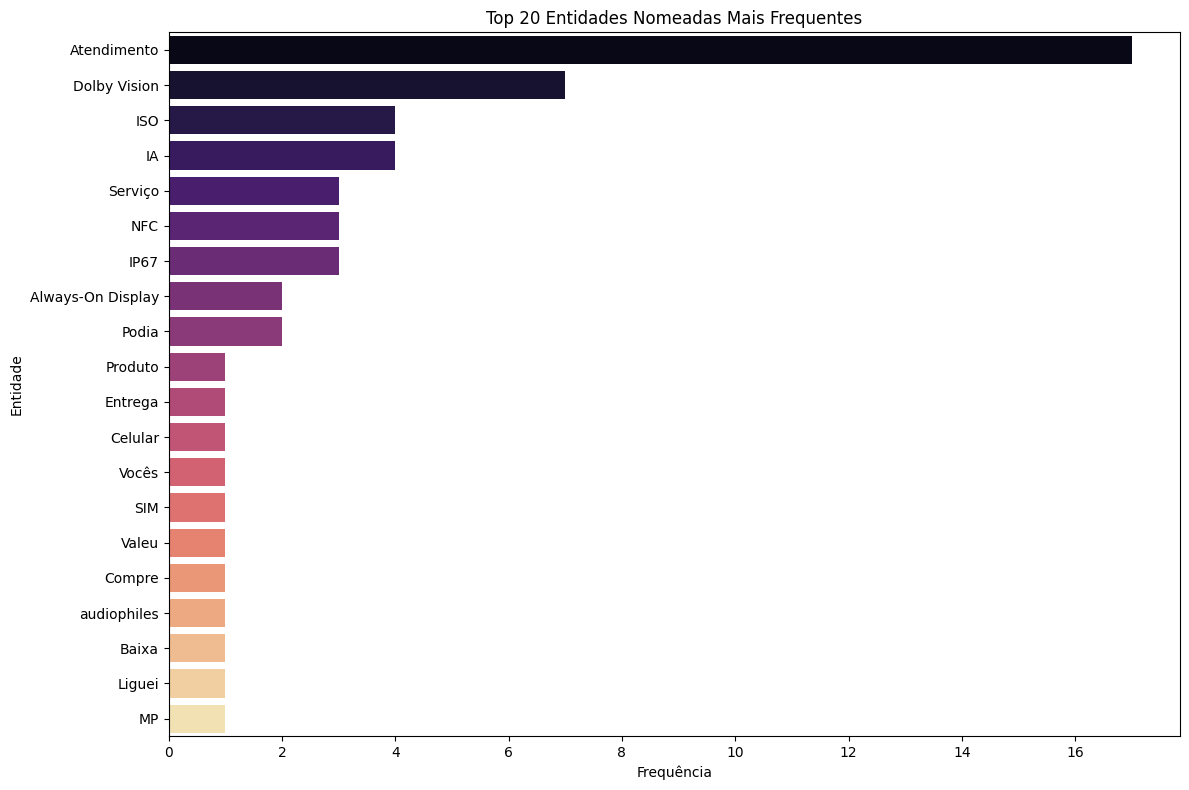

In [ ]:
# Visualização: Frequência das Entidades
entities_df = pd.DataFrame(entity_freq, columns=['Entidade', 'Frequência'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequência', y='Entidade', data=entities_df, palette='magma', hue='Entidade', dodge=False)  # Modified line
plt.title('Top 20 Entidades Nomeadas Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Entidade')
plt.tight_layout()
plt.show()

## 3.5 Análise de N-grams (Bigrams e Trigrams com TF-IDF)

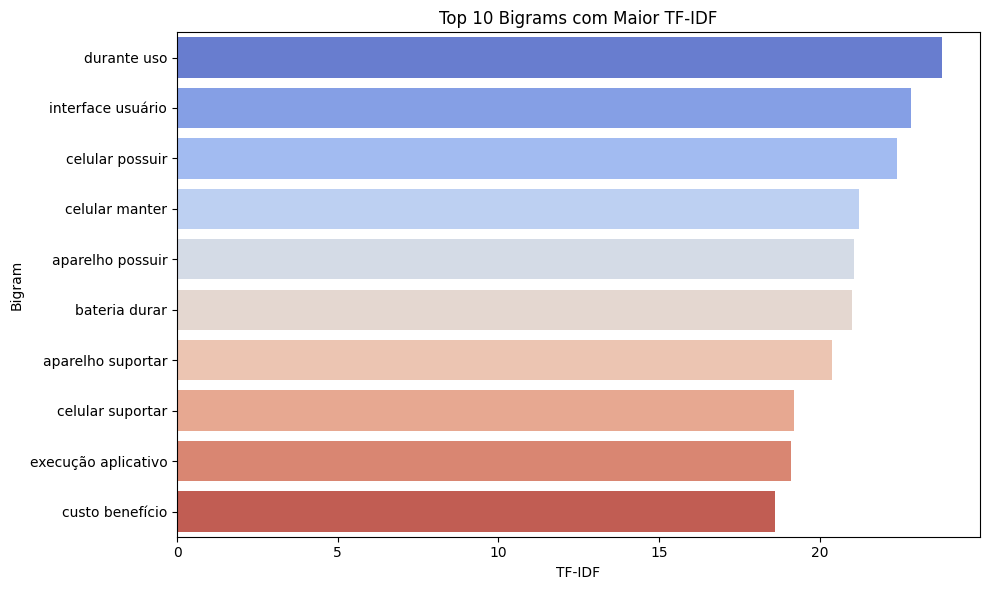

In [ ]:
# Análise de N-grams Avançada (Bigrams e Trigrams com TF-IDF)
def get_top_ngrams(corpus, n=None, top=None):
    vec = TfidfVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

top_bigrams = get_top_ngrams(df['clean_review'], n=2, top=10)
top_trigrams = get_top_ngrams(df['clean_review'], n=3, top=10)

# Visualização de Bigrams
bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'TF-IDF'])
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF', y='Bigram', data=bigrams_df, hue='Bigram', palette='coolwarm', dodge=False, legend=False) # Modified line
plt.title('Top 10 Bigrams com Maior TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()

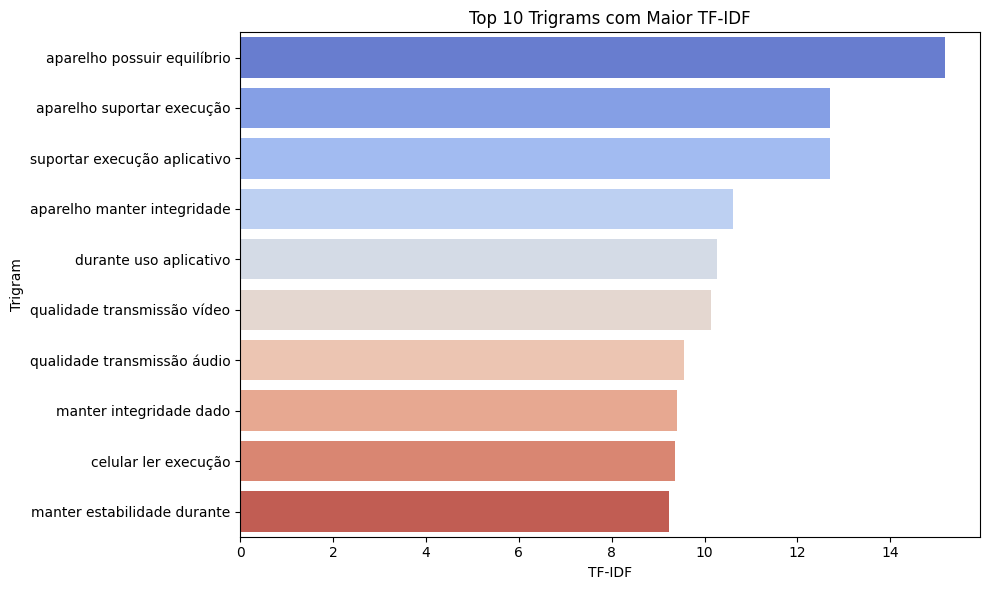

In [ ]:
# Visualização de Trigrams
trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'TF-IDF'])
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF', y='Trigram', data=trigrams_df, hue='Trigram', palette='coolwarm', dodge=False, legend=False)
plt.title('Top 10 Trigrams com Maior TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Trigram')
plt.tight_layout()
plt.show()

## 3.6 Análise do Comprimento da Avaliação vs. Nota com Regressão

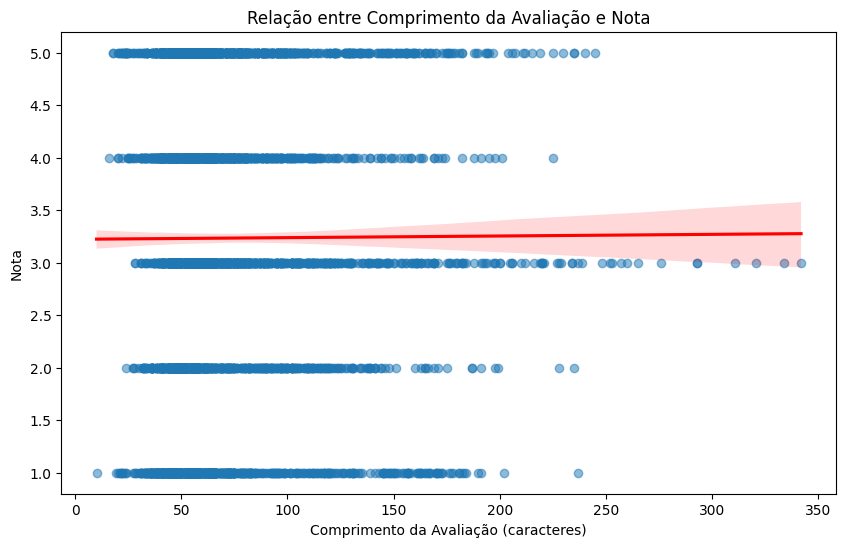

In [ ]:
# Análise do Comprimento da Avaliação vs. Nota com Regressão
df['review_length'] = df['review'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.regplot(x='review_length', y='rating', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relação entre Comprimento da Avaliação e Nota')
plt.xlabel('Comprimento da Avaliação (caracteres)')
plt.ylabel('Nota')
plt.show()

### Correlação entre Comprimento da Avaliação e Nota

In [ ]:
# Calcular e imprimir a correlação
correlation = df['review_length'].corr(df['rating'])
print("-" * 50)
print(f"Coeficiente de correlação de Pearson: {correlation:.2f}")
print("-" * 50)

--------------------------------------------------
Coeficiente de correlação de Pearson: 0.00
--------------------------------------------------


# 4. Treinamento de Classificadores

## 4.1 SVM + Bag of Words (BoW)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Divide o dataset
X_train, X_test, y_train, y_test = train_test_split(df["clean_review"], df["rating"], test_size=0.2, random_state=42)

# Atualiza a pipeline usando TF-IDF no lugar de CountVectorizer
pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", SVC())
])

# Grade de parâmetros para o GridSearch
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [1000, 3000, 5000],
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"]
}

# Aplica o GridSearch para encontrar a melhor combinação de hiperparâmetros
grid_search = GridSearchCV(pipeline_tfidf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtém o melhor modelo
best_svm_model = grid_search.best_estimator_

# Faz a predição no conjunto de teste
y_pred_bow = best_svm_model.predict(X_test)

### Avaliação dos Resultados para o SVM + Bag of Words (BoW)

In [ ]:
# Avaliação
print("SVM + Bag of Words")
print(classification_report(y_test, y_pred_bow))

# Calcula a acurácia e F1 score
accuracy_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

print(f"Accuracy: {accuracy_bow}")
print(f"F1-score: {f1_bow}")

SVM + Bag of Words
              precision    recall  f1-score   support

           1       0.74      0.78      0.76       157
           2       0.62      0.43      0.51       129
           3       0.60      0.73      0.65       193
           4       0.57      0.39      0.46       144
           5       0.65      0.76      0.70       217

    accuracy                           0.64       840
   macro avg       0.64      0.62      0.62       840
weighted avg       0.64      0.64      0.63       840

Accuracy: 0.6404761904761904
F1-score: 0.6305711851281793


### Matriz de Confusão para o SVM + Bag of Words (BoW)

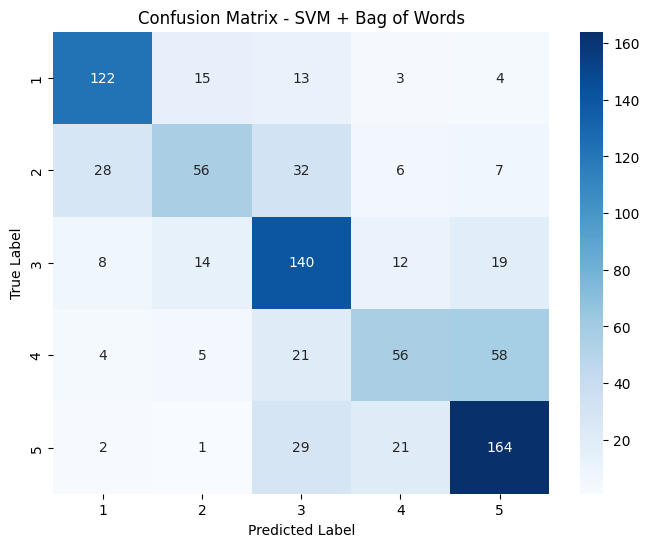

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to create a confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot the confusion matrix for the BoW model
plot_confusion_matrix(y_test, y_pred_bow, title="Confusion Matrix - SVM + Bag of Words")

## 4.2 SVM + Embeddings

Uso de `spacy` para converter as avaliações em embeddings e treinar o SVM com esses vetores.

In [ ]:
# Faz o Download do Modelo de Linguagem PT-BR
!python -m spacy download pt_core_news_md

import spacy
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Usa embeddings do spaCy
nlp = spacy.load("pt_core_news_md")
X_train_embedded = [nlp(text).vector for text in X_train]
X_test_embedded = [nlp(text).vector for text in X_test]

# Normaliza os embeddings
scaler = StandardScaler()
X_train_embedded = scaler.fit_transform(X_train_embedded)
X_test_embedded = scaler.transform(X_test_embedded)

# Treina o SVM com embeddings
svm_embedding = SVC()
svm_embedding.fit(X_train_embedded, y_train)
y_pred_embed = svm_embedding.predict(X_test_embedded)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 14.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Avaliação dos Resultados para o SVM + Embeddings

In [ ]:
# Avaliação
print("SVM + Embeddings")
print(classification_report(y_test, y_pred_embed))

# Calcula a acurácia e F1 score
accuracy_embed = accuracy_score(y_test, y_pred_embed)
f1_embed = f1_score(y_test, y_pred_embed, average='weighted')

print(f"Accuracy: {accuracy_embed}")
print(f"F1-score: {f1_embed}")

SVM + Embeddings
              precision    recall  f1-score   support

           1       0.68      0.75      0.72       157
           2       0.52      0.29      0.38       129
           3       0.56      0.67      0.61       193
           4       0.61      0.35      0.45       144
           5       0.60      0.77      0.68       217

    accuracy                           0.60       840
   macro avg       0.60      0.57      0.57       840
weighted avg       0.60      0.60      0.58       840

Accuracy: 0.6
F1-score: 0.5830386318478644


### Matriz de Confusão para o SVM + Embedding

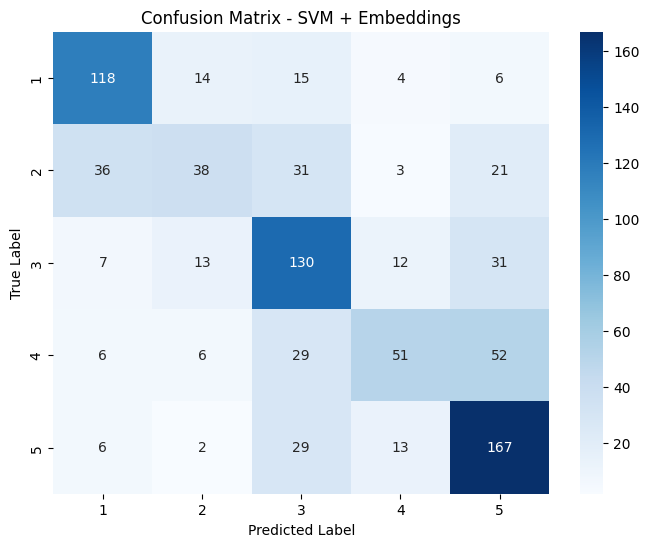

In [ ]:
plot_confusion_matrix(y_test, y_pred_embed, title="Confusion Matrix - SVM + Embeddings")

## 4.3 BERT para Classificação

Usando `transformers` para fine-tuning de um modelo BERT para classificação de sentimentos.

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay

import tensorflow as tf

# Restringe o TensorFlow para usar apenas a CPU
# tf.config.set_visible_devices([], 'GPU')

# Prepara o modelo BERT
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = TFBertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=5)

# Tokeniza os dados
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="tf")
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="tf")

# Define o otimizador e a função de perda
optimizer = AdamWeightDecay(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

# Loop de treinamento personalizado
def train_step(inputs, targets):
    # Subtrai 1 dos targets para ajustar o intervalo para 0-4
    targets = targets - 1
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(targets, predictions.logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    metrics.update_state(targets, predictions.logits)
    return loss, metrics.result()

# Loop de Treinamento
epochs = 4
batch_size =8
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(X_train), batch_size):
        batch_inputs = {k: v[i:i + batch_size] for k, v in X_train_tokens.data.items()}
        batch_targets = y_train[i:i + batch_size]
        # Subtraindo 1 dos targets para ajustar o intervalo para 0-4
        loss, accuracy = train_step(batch_inputs, batch_targets)
        print(f"Batch {i // batch_size + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/529M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/4
Batch 1: Loss = 1.6296, Accuracy = 0.2500
Batch 2: Loss = 1.5864, Accuracy = 0.3125
Batch 3: Loss = 1.5552, Accuracy = 0.3333
Batch 4: Loss = 1.6389, Accuracy = 0.2812
Batch 5: Loss = 1.7983, Accuracy = 0.2250
Batch 6: Loss = 1.6656, Accuracy = 0.2083
Batch 7: Loss = 1.5343, Accuracy = 0.2321
Batch 8: Loss = 1.5672, Accuracy = 0.2500
Batch 9: Loss = 1.6207, Accuracy = 0.2500
Batch 10: Loss = 1.6287, Accuracy = 0.2375
Batch 11: Loss = 1.5582, Accuracy = 0.2273
Batch 12: Loss = 1.6146, Accuracy = 0.2083
Batch 13: Loss = 1.5262, Accuracy = 0.2404
Batch 14: Loss = 1.5892, Accuracy = 0.2321
Batch 15: Loss = 1.5451, Accuracy = 0.2417
Batch 16: Loss = 1.4221, Accuracy = 0.2656
Batch 17: Loss = 1.4126, Accuracy = 0.2794
Batch 18: Loss = 1.3968, Accuracy = 0.2847
Batch 19: Loss = 1.3759, Accuracy = 0.2961
Batch 20: Loss = 1.6103, Accuracy = 0.2937
Batch 21: Loss = 1.2849, Accuracy = 0.3036
Batch 22: Loss = 1.4100, Accuracy = 0.3125
Batch 23: Loss = 1.6807, Accuracy = 0.3043
Batch 24: 

### Avaliação dos Resultados para o BERT

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Avaliação
predictions = model(X_test_tokens.data).logits

# Obtém os rótulos previstos a partir dos logits
predicted_labels = np.argmax(predictions, axis=1)

# Ajusta y_test para o intervalo 0-4 para avaliação (se necessário)
y_test_adjusted = y_test - 1

# Calcula as métricas
accuracy_bert = accuracy_score(y_test_adjusted, predicted_labels)
f1_bert = f1_score(y_test_adjusted, predicted_labels, average='weighted')
loss = loss_fn(y_test_adjusted, predictions) # Calcula a perda após o ajuste do y_test

print("\nBERT:")
print(f"Test Loss: {loss:.4f}") # Imprime a perda
print(f"Acurácia: {accuracy_bert:.4f}")
print(f"F1 Score: {f1_bert:.4f}")


BERT:
Test Loss: 1.1388
Acurácia: 0.6429
F1 Score: 0.6397


### Matriz de Confusão para o Resultado do BERT

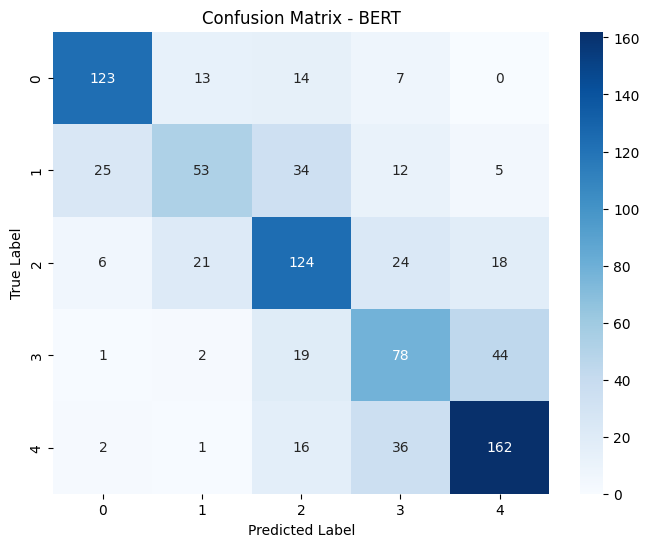

In [ ]:
# ### Matriz de Confusão para o Resultado do BERT
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the confusion matrix for the BERT model
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test_adjusted, predicted_labels, title="Confusion Matrix - BERT")

# 5. Comparativo de Métricas e Resultados

Resultado comparativo entre os três modelos (SVM + BoW, SVM + Embebddings e BERT).

In [ ]:
# Cria um dicionário com os resultados
resultados = {
    "Modelo": ["SVM + Bag of Words", "SVM + Embeddings", "BERT"],
    "Acurácia": [accuracy_bow, accuracy_embed, accuracy_bert],
    "F1-Score": [f1_bow, f1_embed, f1_bert]
}

# Cria um DataFrame pandas com os resultados
df_resultados = pd.DataFrame(resultados)

# Exibe o DataFrame
print(df_resultados)

               Modelo  Acurácia  F1-Score
0  SVM + Bag of Words  0.640476  0.630571
1    SVM + Embeddings  0.600000  0.583039
2                BERT  0.642857  0.639727


### Gráfico com Comparação de Desempenho dos Modelos

<Figure size 1000x600 with 0 Axes>

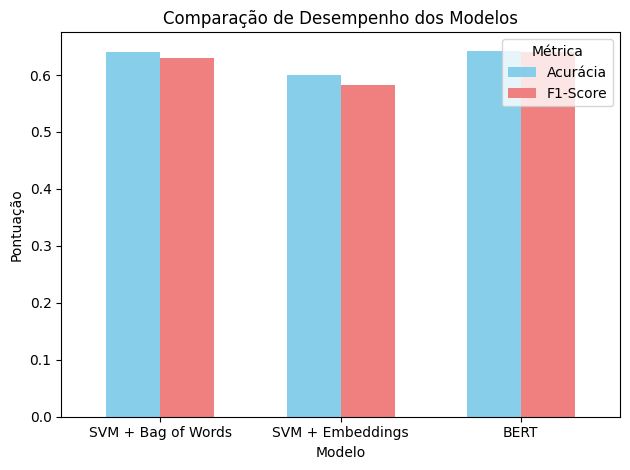

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
df_resultados.plot(x="Modelo", y=["Acurácia", "F1-Score"], kind="bar", width=0.6, color=['skyblue', 'lightcoral'])
plt.title("Comparação de Desempenho dos Modelos")
plt.ylabel("Pontuação")
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.tight_layout()
plt.show()

# 6. Classificação com In-Context Learning (Bônus)

Utilizando LLM para realizar a classificação de sentimentos diretamente com poucas instruções, sem a necessidade de treinamento explícito.

In [ ]:
# Define o temeplate do prompt
prompt_template = """
Você é um assistente de análise de sentimentos. Sua tarefa é classificar avaliações de produtos como "positivo", "negativo" ou "neutro".

Aqui está uma avaliação de um produto:
{review_text}

Classifique a avaliação acima como "Positivo", "Neutro" ou "Negativo". Responda apenas com a classificação, sem adicionar comentários ou explicações adicionais.
"""

# Define função para exibição da classificação
def add_emoji_to_classification(classification):
  if classification == "Positivo":
    return "😊 " + classification
  elif classification == "Neutro":
    return "😐 " + classification
  elif classification == "Negativo":
    return "😞 " + classification
  else:
    return classification

# Define função para comparação com resultado da coluna "sentiment"
def compare_classification_with_actual(classification, actual_sentiment):
  is_correct = classification.lower() == actual_sentiment.lower()
  result = "✅ Correto" if is_correct else "❌ Incorreto"
  return result, is_correct

## 6.1 Using OpenAI (GPT-4o)

In [ ]:
!pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata

In [ ]:
from google.colab import userdata
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(
    model_name="gpt-4o",
    temperature=0
)

def classify_with_openai(review_text):
    prompt = prompt_template.format(review_text=review_text)

    response = llm.predict(prompt)
    return response.strip()

random_reviews = df.sample(n=10)

print("Classificação da OpenAI GPT-4")
print("=" * 90)

for index, row in random_reviews.iterrows():
    review_text = row['review']
    classification = classify_with_openai(review_text)
    display_classification = add_emoji_to_classification(classification)
    result, is_correct = compare_classification_with_actual(classification, row['sentiment'])

    print(f"\nAvaliação: {review_text}")
    print(f"Classificação da OpenAI: {display_classification}")
    print("-" * 90)
    print(f"Sentimento Real: {row['sentiment'].capitalize()}")
    print(f"Resultado: {result}")

Classificação da OpenAI GPT-4


<ipython-input-32-7fec6ff9806c>:14: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm.predict(prompt)



Avaliação: O som dos alto-falantes é adequado para chamadas e músicas baixas.
Classificação da OpenAI: 😐 Neutro
------------------------------------------------------------------------------------------
Sentimento Real: Neutro
Resultado: ✅ Correto

Avaliação: Tela com tecnologia de escurecimento local para pretos mais profundos e maior contraste.
Classificação da OpenAI: 😊 Positivo
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resultado: ✅ Correto

Avaliação: O aparelho possui um bom equilíbrio entre design elegante e funcionalidade prática.
Classificação da OpenAI: 😊 Positivo
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resultado: ✅ Correto

Avaliação: Veio com arranhões, mas nada que comprometa o uso.
Classificação da OpenAI: 😐 Neutro
------------------------------------------------------------------------------------------
Sentimento Real: N

## 6.2 Using Google Gemini 1.5

In [ ]:
from google.colab import userdata
import google.generativeai as genai

# Retorna a chave de API do Google Gemini do userdata
myKey = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=myKey)

# Espcifica o modelo do Gemini
model = genai.GenerativeModel("gemini-1.5-flash-latest")

def classify_with_gemini(review_text):
    response = model.generate_content(prompt_template.format(review_text=review_text))
    classification = response.text.strip()
    return classification

# Classifica 10 reviews aleatórias
random_reviews = df.sample(n=10)

print("Classificação do Google Gemini 1.5")
print("=" * 90)

for index, row in random_reviews.iterrows():
    review_text = row['review']
    classification = classify_with_gemini(review_text)

    # Adiciona o emoji
    display_classification = add_emoji_to_classification(classification)

    # Compara o resultado com o sentimento correto
    result, is_correct = compare_classification_with_actual(classification, row['sentiment'])

    print(f"\nAvaliação: {review_text}")
    print(f"Classificação do Gemini: {display_classification}")
    print("-" * 90)
    print(f"Sentimento Real: {row['sentiment'].capitalize()}")
    print(f"Resultado: {result}")

Classificação do Google Gemini 1.5

Avaliação: A embalagem veio danificada, mas o produto está em perfeitas condições.
Classificação do Gemini: 😐 Neutro
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resultado: ❌ Incorreto

Avaliação: O celular é resistente a água e poeira, ideal para usar em qualquer ambiente.
Classificação do Gemini: 😊 Positivo
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resultado: ✅ Correto

Avaliação: A tela com alta taxa de amostragem de toque oferece uma resposta rápida e precisa aos comandos, ideal para jogos e aplicativos que exigem precisão.
Classificação do Gemini: 😊 Positivo
------------------------------------------------------------------------------------------
Sentimento Real: Positivo
Resultado: ✅ Correto

Avaliação: O aparelho mantém a integridade dos dados durante sincronizações com serviços de armazenamento ex